In [1]:
import pickle
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Read in data from from online source
df = pd.read_pickle("./semicon_wafer.pkl")

In [ ]:

df.iloc[100,0]

In [ ]:
# Example of wafer from dataset
image = df.iloc[100,0]
plt.imshow(image, interpolation='none')

In [ ]:
df.iloc[100,0].shape

In [ ]:
# About 80% of the data set has not been classified by failure type, so i'm nixing the non-classifieds to save 
# processing time.
df = df.loc[df['failure type'] != '']

In [ ]:
# I've designed this function to clear out noise on the wafers. The wafer pixels can be one of three integers;
# 0, 1, or 2. A 0 is background, a 1 is non-fault, and a 2 represents a fault. Many fault pixels arise randomly
# on even categorically faultless wafers, and some are liable to distract the network from predicting the true
# fault concentration properly. This function will find fault pixels that do no have a fault pixel on either side
# of them, and will delete them. It will then transpose the wafer and run the same sweep. Finally it will transpose
# the wafer again back to the original orientation and return the "cleaned" wafer.

def clean_wafer(array):
    list5 = list(array)
    
    array3 = []
    for i in list5:
        r = list(i)


        r.insert(0, -1)
        r.append(-1)
        for i in range(1, len(r) - 1):
            if r[i] == 2 and r[i-1] != 2 and r[i+1] != 2:
                r[i] = 1
        array2 = r[1:-1]


        array4 = np.asarray(array2)
        array3.append(array4)
    array5 = np.asarray(array3, dtype=np.uint8)
    
    array6 = array5.transpose()
    
    list5 = list(array6)
    
    array3 = []
    for i in list5:
        r = list(i)


        r.insert(0, -1)
        r.append(-1)
        for i in range(1, len(r) - 1):
            if r[i] == 2 and r[i-1] != 2 and r[i+1] != 2:
                r[i] = 1
        array2 = r[1:-1]


        array4 = np.asarray(array2)
        array3.append(array4)
    array9 = np.asarray(array3, dtype=np.uint8)
    
    array10 = array9.transpose()
    return array10

In [ ]:
# Building a list of clean wafers using the previous function
list50 = []
counter = 0
for index, row in df.iterrows():
    array = row[0]
    array50 = clean_wafer(array)
    list50.append(array50)
    counter +=1
    print(counter)

In [ ]:
# This will be the column of clean wafers
df['clean wafer'] = list50

In [ ]:
df = df.reset_index(drop=True)
df

In [ ]:
# Since I have to resize all the wafers to a single matrix size in order to run them in my NN, I've chosen to
# remove any wafers that will not resize well. This means removing wafers that are either too small or too big
# to maintain reasonable image quality upon resizing.

df = df[df['die size'] >= 924]
df = df[df['die size'] <= 2857]
df = df[df['failure type'] != 'Near-full']
df = df.reset_index(drop=True)
df

In [ ]:
df.groupby('failure type', as_index = False)['lot number'].count()

In [ ]:
# I'd like to have an even number of samples in each class. This means removing a large number of no-fault wafers.

df = df.drop(df[df['failure type'] == 'none'].sample(frac=.9).index)

In [ ]:
df.groupby('failure type', as_index = False)['lot number'].count()

In [ ]:
df = df.drop(df[df['failure type'] == 'none'].sample(frac=.4).index)

In [ ]:
df.groupby('failure type', as_index = False)['lot number'].count()

In [ ]:
# Same here, twice as many Edge-Ring fault wafers as I can use. I explain why i'm trying to get down to 3000
# wafers here down below. 

df = df.drop(df[df['failure type'] == 'Edge-Ring'].sample(frac=.5).index)
df.groupby('failure type', as_index = False)['lot number'].count()

In [ ]:
df.to_pickle(r'semicon_wafer2.pkl')

In [ ]:
df = pd.read_pickle(r'semicon_wafer2.pkl')
df = df.reset_index(drop=True)
df

In [ ]:
# At this point, I want to upsample as much as I can from the low representation wafer fault classes. The Donut 
# class has the lowest at about 400, but what i've done here is i've rotated each donut wafer by 90, 180, and 270
# degrees, then taken its transpose and rotated again 3x. This allowed me to increase sample size 8x, bringing 
# donut fault samples near to  the 3k mark. The rest hear have been upsampled to roughly 3k instaces using the
# same methods.

df1 = pd.DataFrame()
for index, row in df.iterrows():
    
    if row[5] == 'Center':
        row[0] = np.rot90(row[0], 1)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c1'
        df1 = df1.append(row)
        row[0] = np.rot90(row[0], 2)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3][:-2]) + 'c2'
        df1 = df1.append(row)
        
    elif row[5] == 'Donut':
        row[0] = np.rot90(row[0], 1)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c1'
        df1 = df1.append(row)
        row[0] = np.rot90(row[0], 2)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c2'
        df1 = df1.append(row)
        row[0] = np.rot90(row[0], 3)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c3'
        df1 = df1.append(row)
        row[0] = row[0].transpose()
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c4'
        df1 = df1.append(row)
        row[0] = np.rot90(row[0], 1)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c5'
        df1 = df1.append(row)
        row[0] = np.rot90(row[0], 2)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c6'
        df1 = df1.append(row)
        row[0] = np.rot90(row[0], 3)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c7'
        df1 = df1.append(row)
        
    elif row[5] == 'Loc':
        row[0] = row[0].transpose()
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c1'
        df1 = df1.append(row)
        
    elif row[5] == 'Random':
        row[0] = np.rot90(row[0], 1)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c1'
        df1 = df1.append(row)
        row[0] = np.rot90(row[0], 2)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c2'
        df1 = df1.append(row)
        row[0] = np.rot90(row[0], 3)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c3'
        df1 = df1.append(row)
        row[0] = row[0].transpose()
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c4'
        df1 = df1.append(row)
        row[0] = np.rot90(row[0], 1)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c5'
        df1 = df1.append(row)
        
    elif row[5] == 'Scratch':
        row[0] = np.rot90(row[0], 1)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c1'
        df1 = df1.append(row)
        row[0] = np.rot90(row[0], 2)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c2'
        df1 = df1.append(row)
        row[0] = np.rot90(row[0], 3)
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c3'
        df1 = df1.append(row)
        row[0] = row[0].transpose()
        row[6] = clean_wafer(row[0])
        row[3] = str(row[3]) + 'c4'
        df1 = df1.append(row)

In [ ]:
df = df.append(df1)

In [ ]:
df.groupby('failure type', as_index = False)['lot number'].count()

In [ ]:
df

In [ ]:
list100 = []
for index, row in df.iterrows():
    if row[5] == 'Center':
        list100.append(0)
    elif row[5] == 'Donut':
        list100.append(1)
    elif row[5] == 'Edge-Loc':
        list100.append(2)
    elif row[5] == 'Edge-Ring':
        list100.append(3)
    elif row[5] == 'Loc':
        list100.append(4)
    elif row[5] == 'Random':
        list100.append(5)
    elif row[5] == 'Scratch':
        list100.append(6)
    elif row[5] == 'none':
        list100.append(7)

In [ ]:
df['failure type int'] = list100

In [ ]:
df['failure type int'].dtype

In [ ]:
df.to_pickle(r'semicon_wafer3.pkl')

In [2]:
df = pd.read_pickle(r'semicon_wafer3.pkl')

In [5]:
del df['train/test']

In [6]:
df

,wafer map,die size,lot number,wafer index,failure type,clean wafer,failure type int
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,15,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,16,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20,Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,4,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12,Edge-Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2
...,...,...,...,...,...,...,...
13151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1060.0,lot47471,12c1,Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
13152,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1060.0,lot47471,14c1,Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
13153,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1060.0,lot47471,16c1,Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
13154,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1060.0,lot47471,18c1,Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4


In [7]:
# Here I resize the original wafers left over from the previous cuts and augmentations. There are 5 resize options
# in cv2. Here I've made lists of all of them, and then added those lists to my dataframe. I do the same thing 
# with the clean wafers as well down below.

res_inter_area = []
res_inter_cubic = []
res_inter_lanczos4 = []
res_inter_nearest = []
res_inter_linear = []
for index, row in df.iterrows():
    array1 = row[0]
    res = cv2.resize(array1, dsize=(40, 40), interpolation=cv2.INTER_AREA)
    res1 = cv2.resize(array1, dsize=(40, 40), interpolation=cv2.INTER_CUBIC)
    res2 = cv2.resize(array1, dsize=(40, 40), interpolation=cv2.INTER_LANCZOS4)
    res3 = cv2.resize(array1, dsize=(40, 40), interpolation=cv2.INTER_NEAREST)
    res4 = cv2.resize(array1, dsize=(40, 40), interpolation=cv2.INTER_LINEAR)
    res_inter_area.append(res)
    res_inter_cubic.append(res1)
    res_inter_lanczos4.append(res2)
    res_inter_nearest.append(res3)
    res_inter_linear.append(res4)

In [8]:
df['res INTER_AREA'] = res_inter_area
df['res INTER_CUBIC'] = res_inter_cubic
df['res INTER_LANCZOS4'] = res_inter_lanczos4
df['res INTER_NEAREST'] = res_inter_nearest
df['res INTER_LINEAR'] = res_inter_linear

In [9]:
df = df.reset_index(drop=True)

In [10]:
df

,wafer map,die size,lot number,wafer index,failure type,clean wafer,failure type int,res INTER_AREA,res INTER_CUBIC,res INTER_LANCZOS4,res INTER_NEAREST,res INTER_LINEAR
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,15,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,16,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20,Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,4,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12,Edge-Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
24232,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1060.0,lot47471,12c1,Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,..."
24233,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1060.0,lot47471,14c1,Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
24234,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1060.0,lot47471,16c1,Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,..."
24235,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1060.0,lot47471,18c1,Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,..."


In [11]:
# Clean wafers being resized to 40x40.

res_inter_area = []
res_inter_cubic = []
res_inter_lanczos4 = []
res_inter_nearest = []
res_inter_linear = []
for index, row in df.iterrows():
    array1 = row[5]
    res = cv2.resize(array1, dsize=(40, 40), interpolation=cv2.INTER_AREA)
    res1 = cv2.resize(array1, dsize=(40, 40), interpolation=cv2.INTER_CUBIC)
    res2 = cv2.resize(array1, dsize=(40, 40), interpolation=cv2.INTER_LANCZOS4)
    res3 = cv2.resize(array1, dsize=(40, 40), interpolation=cv2.INTER_NEAREST)
    res4 = cv2.resize(array1, dsize=(40, 40), interpolation=cv2.INTER_LINEAR)
    res_inter_area.append(res)
    res_inter_cubic.append(res1)
    res_inter_lanczos4.append(res2)
    res_inter_nearest.append(res3)
    res_inter_linear.append(res4)

In [12]:
df['res clean INTER_AREA'] = res_inter_area
df['res clean INTER_CUBIC'] = res_inter_cubic
df['res clean INTER_LANCZOS4'] = res_inter_lanczos4
df['res clean INTER_NEAREST'] = res_inter_nearest
df['res clean INTER_LINEAR'] = res_inter_linear

In [13]:
df

,wafer map,die size,lot number,wafer index,failure type,clean wafer,failure type int,res INTER_AREA,res INTER_CUBIC,res INTER_LANCZOS4,res INTER_NEAREST,res INTER_LINEAR,res clean INTER_AREA,res clean INTER_CUBIC,res clean INTER_LANCZOS4,res clean INTER_NEAREST,res clean INTER_LINEAR
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,15,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,16,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20,Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,4,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12,Edge-Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24232,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1060.0,lot47471,12c1,Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[0

In [14]:
# Upon realizing I had to make a choice for which resize interpolation methods to use, and that some would be
# better for upsizing and others better for downsizing, I did some research to figure what combinations would be
# best. Ultimately, I decided to use inter_area interpolation for all downsizing, and inter_linear and inter_cubic
# for upsizing. I did this for both the original wafers and the "clean" wafers, resulting in 4 distinct sets for 
# possible use in the NN.

interarea_intercubic = []
interarea_interlinear = []
interarea_intercubic_clean = []
interarea_interlinear_clean = []
for index, row in df.iterrows():
    if row[1] >= 1600:
        interarea_intercubic.append(row[7])
        interarea_interlinear.append(row[7])
        interarea_intercubic_clean.append(row[12])
        interarea_interlinear_clean.append(row[12])
    if row[1] < 1600:
        interarea_intercubic.append(row[8])
        interarea_interlinear.append(row[11])
        interarea_intercubic_clean.append(row[13])
        interarea_interlinear_clean.append(row[16])

In [15]:
df['interarea_intercubic'] = interarea_intercubic
df['interarea_interlinear'] = interarea_interlinear
df['interarea_intercubic_clean'] = interarea_intercubic_clean
df['interarea_interlinear_clean'] = interarea_interlinear_clean

In [17]:
# To save space in the final pickle, I've deleted any columns added to the dataframe since the start that won't
# be used in modeling, along with any columns not relevant to the overall analysis. 

del df['res INTER_LANCZOS4']
del df['res clean INTER_LANCZOS4']
del df['res clean INTER_NEAREST']

In [18]:
del df['res INTER_NEAREST']

In [19]:
del df['res INTER_AREA']
del df['res INTER_CUBIC']
del df['res INTER_LINEAR']
del df['res clean INTER_AREA']
del df['res clean INTER_CUBIC']
del df['res clean INTER_LINEAR']

In [20]:
df.head()

,wafer map,die size,lot number,wafer index,failure type,clean wafer,failure type int,interarea_intercubic,interarea_interlinear,interarea_intercubic_clean,interarea_interlinear_clean
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,15,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,16,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20,Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,4,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12,Edge-Loc,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


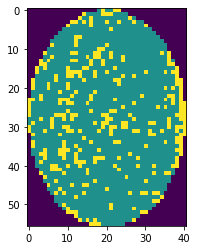

In [22]:
# Just to check that I haven't messed up the order of anything in the dataframe
image = df.iloc[1000,0]
plt.imshow(image, interpolation='none')

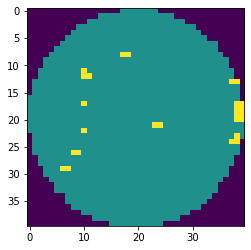

In [25]:
image = df.iloc[1000,7]
plt.imshow(image, interpolation='none')

In [21]:
# File saved as pickle to be used for the NN in another notebook.

df.to_pickle('./semicon_wafer_final.pkl')